In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot as plt
import sys
import _pickle as cPickle
import gzip
import math
import numpy as np
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
display(tf.__version__)

# Helper function to display digit images
def show_sample(images, labels, sample_count=25):
  # Create a square with can fit {sample_count} images
    grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
    grid_count = min(grid_count, len(images), len(labels))
  
    plt.figure(figsize=(2*grid_count, 2*grid_count))
    for i in range(sample_count):
        plt.subplot(grid_count, grid_count, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(images[i]), cmap=plt.cm.gray)
        plt.xlabel(labels[i])
    plt.show()
  

'2.7.0'

In [4]:
# # ----------------------------------------------------------------------------------------------------------------------------------------
# load pubgTest
pubgTestroot = '/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/activeempty_gun/gun_data_preparation/testdata_24x14/'
# pubgTestroot = '/local/mnt2/qtlvas/users/eshahria/workspace/COD/SpeedDetection/data/TestDigit/'
# pubgTestroot = '/local/mnt2/qtlvas/users/eshahria/workspace/HapticDetection/OCRDetection/data/LR1200TestByMuhua/'

pubgTrainroot = '/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/activeempty_gun/gun_data_preparation/Syntheticdata/'
# pubgTrainroot='/local/mnt2/qtlvas/users/eshahria/workspace/COD/SpeedDetection/data/SyntheticData/'

Testfilelist= os.listdir(pubgTestroot)

x_test_pubg= np.zeros([len(Testfilelist),14,21,1])
y_test_pubg= np.zeros([len(Testfilelist),1])

display(x_test_pubg.shape,y_test_pubg.shape)

for imgindex in range(len(Testfilelist)):
    imgcrop  = cv2.imread(pubgTestroot+Testfilelist[imgindex],0)
    #display(imgindex,imgcrop.shape)
    
    # imgcropscaled = cv2.resize(imgcrop, (24,14))
    x_test_pubg[imgindex,:,:,0]=np.float32(imgcrop[:,1:22]>150)*255
    label = Testfilelist[imgindex][0:3]
    #display(label)
    spindex= label.find('_')
    if spindex>0:
         label=label[:spindex]
    y_test_pubg[imgindex,0]= int(label)
    #display(y_test_pubg)
    # x_test_pubg[imgindex,:,:,0]= cv2.imread(pubgTestroot+Testfilelist[imgindex],0)
    # y_test_pubg[imgindex,0]= int(Testfilelist[imgindex][0:3])
    
x_test_pubg=x_test_pubg/255.00
# y_test_pubg = y_test_pubg
filelist= os.listdir(pubgTrainroot)
np.random.shuffle((filelist))
x_train_pubg= np.zeros([len(filelist),14,21,1])
y_train_pubg= np.zeros([len(filelist),1])
for imgindex in range(len(filelist)):
    x_train_pubg[imgindex,:,:,0]= np.float32(cv2.imread(pubgTrainroot+filelist[imgindex],0)[:,1:22] >150)*255
    label = filelist[imgindex][0:3]
    spindex= label.find('_')
    if spindex>0:
        label=label[:spindex]
    y_train_pubg[imgindex,0]= int(label)
x_train_pubg=x_train_pubg/255.00

(89, 14, 21, 1)

(89, 1)

In [5]:
print("X_train original shape", x_train_pubg.shape)
print("y_train original shape", y_train_pubg.shape)
print("X_test original shape", x_test_pubg.shape)
print("y_test original shape", y_test_pubg.shape)

X_train original shape (3000, 14, 21, 1)
y_train original shape (3000, 1)
X_test original shape (89, 14, 21, 1)
y_test original shape (89, 1)


In [6]:
# -----------------------------------------------------------------------------
# x_train = x_train/255.0
# x_test = x_test/255.0

# show_sample(x_train, y_train)

num_orientation= 501
# Mnist model -------------------
# Define the model architecture
model = keras.Sequential([
    # keras.layers.Flatten(input_shape=(14, 20,1)),
    # keras.layers.Dense(128, activation=tf.nn.relu),

# Optional: You can replace the dense layer above with the convolution layers below to get higher accuracy.
    # keras.layers.Reshape(target_shape=( 14, 20, 1)),    
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=tf.nn.relu, input_shape = (14, 21, 1), name='input'),
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(input_shape=(14, 21)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(num_orientation, name='output')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 12, 19, 16)        160       
                                                                 
 conv2d (Conv2D)             (None, 10, 17, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 8, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 8, 16)          0         
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 64)                41024     
                                                        

In [7]:
print(x_train_pubg.shape,y_train_pubg.shape)
# print(y_train_pubg)

(3000, 14, 21, 1) (3000, 1)


In [8]:
# model training  -------------------------------------------------------------

# Train the digit classification model
#model.fit(x_train, y_train, epochs=5)
testaccset=[]
for k in range(20):
    training_history = model.fit(x_train_pubg, y_train_pubg, batch_size=1024, epochs=30)
    #training_history = model.fit(x_train_pubg, y_train_pubg, batch_size=1024, epochs=30,validation_split=0.2)
    test_loss, test_acc = model.evaluate(x_test_pubg, y_test_pubg)
    testaccset.append(test_acc)

model.save('./CODSpeedChkpnt_Jan26')


Epoch 1/30
3/3 [==============================] - 0s 27ms/step - loss: 6.2198 - accuracy: 0.0017
Epoch 2/30
3/3 [==============================] - 0s 27ms/step - loss: 6.2053 - accuracy: 0.0057
Epoch 3/30
3/3 [==============================] - 0s 25ms/step - loss: 6.1899 - accuracy: 0.0050
Epoch 4/30
3/3 [==============================] - 0s 26ms/step - loss: 6.1698 - accuracy: 0.0047
Epoch 5/30
3/3 [==============================] - 0s 24ms/step - loss: 6.1347 - accuracy: 0.0023
Epoch 6/30
3/3 [==============================] - 0s 25ms/step - loss: 6.0827 - accuracy: 0.0030
Epoch 7/30
3/3 [==============================] - 0s 26ms/step - loss: 6.0279 - accuracy: 0.0037
Epoch 8/30
3/3 [==============================] - 0s 26ms/step - loss: 5.9997 - accuracy: 0.0043
Epoch 9/30
3/3 [==============================] - 0s 25ms/step - loss: 5.9553 - accuracy: 0.0047
Epoch 10/30
3/3 [==============================] - 0s 26ms/step - loss: 5.8935 - accuracy: 0.0030
Epoch 11/30
3/3 [============

3/3 [==============================] - 0s 26ms/step - loss: 1.5125 - accuracy: 0.5480
Epoch 24/30
3/3 [==============================] - 0s 26ms/step - loss: 1.4995 - accuracy: 0.5490
Epoch 25/30
3/3 [==============================] - 0s 27ms/step - loss: 1.5012 - accuracy: 0.5477
Epoch 26/30
3/3 [==============================] - 0s 28ms/step - loss: 1.4535 - accuracy: 0.5550
Epoch 27/30
3/3 [==============================] - 0s 25ms/step - loss: 1.4105 - accuracy: 0.5713
Epoch 28/30
3/3 [==============================] - 0s 28ms/step - loss: 1.4301 - accuracy: 0.5680
Epoch 29/30
3/3 [==============================] - 0s 25ms/step - loss: 1.3617 - accuracy: 0.5763
Epoch 30/30
3/3 [==============================] - 0s 2ms/step - loss: 17.4676 - accuracy: 0.0112
Epoch 1/30
3/3 [==============================] - 0s 25ms/step - loss: 1.3639 - accuracy: 0.5773
Epoch 2/30
3/3 [==============================] - 0s 27ms/step - loss: 1.3419 - accuracy: 0.5777
Epoch 3/30
3/3 [==================

3/3 [==============================] - 0s 25ms/step - loss: 0.7190 - accuracy: 0.7713
Epoch 15/30
3/3 [==============================] - 0s 26ms/step - loss: 0.6960 - accuracy: 0.7740
Epoch 16/30
3/3 [==============================] - 0s 26ms/step - loss: 0.7163 - accuracy: 0.7633
Epoch 17/30
3/3 [==============================] - 0s 26ms/step - loss: 0.7012 - accuracy: 0.7687
Epoch 18/30
3/3 [==============================] - 0s 24ms/step - loss: 0.6891 - accuracy: 0.7657
Epoch 19/30
3/3 [==============================] - 0s 26ms/step - loss: 0.7034 - accuracy: 0.7667
Epoch 20/30
3/3 [==============================] - 0s 26ms/step - loss: 0.6994 - accuracy: 0.7740
Epoch 21/30
3/3 [==============================] - 0s 25ms/step - loss: 0.7178 - accuracy: 0.7630
Epoch 22/30
3/3 [==============================] - 0s 26ms/step - loss: 0.6882 - accuracy: 0.7703
Epoch 23/30
3/3 [==============================] - 0s 25ms/step - loss: 0.6549 - accuracy: 0.7873
Epoch 24/30
3/3 [===============

3/3 [==============================] - 0s 26ms/step - loss: 0.5212 - accuracy: 0.8247
Epoch 6/30
3/3 [==============================] - 0s 26ms/step - loss: 0.5273 - accuracy: 0.8257
Epoch 7/30
3/3 [==============================] - 0s 26ms/step - loss: 0.5523 - accuracy: 0.8153
Epoch 8/30
3/3 [==============================] - 0s 26ms/step - loss: 0.5186 - accuracy: 0.8267
Epoch 9/30
3/3 [==============================] - 0s 26ms/step - loss: 0.5180 - accuracy: 0.8283
Epoch 10/30
3/3 [==============================] - 0s 26ms/step - loss: 0.5184 - accuracy: 0.8243
Epoch 11/30
3/3 [==============================] - 0s 25ms/step - loss: 0.5550 - accuracy: 0.8140
Epoch 12/30
3/3 [==============================] - 0s 26ms/step - loss: 0.5059 - accuracy: 0.8260
Epoch 13/30
3/3 [==============================] - 0s 25ms/step - loss: 0.5011 - accuracy: 0.8297
Epoch 14/30
3/3 [==============================] - 0s 26ms/step - loss: 0.5275 - accuracy: 0.8207
Epoch 15/30
3/3 [===================

3/3 [==============================] - 0s 25ms/step - loss: 0.4384 - accuracy: 0.8577
Epoch 28/30
3/3 [==============================] - 0s 25ms/step - loss: 0.4471 - accuracy: 0.8503
Epoch 29/30
3/3 [==============================] - 0s 24ms/step - loss: 0.4506 - accuracy: 0.8457
Epoch 30/30
3/3 [==============================] - 0s 2ms/step - loss: 31.4254 - accuracy: 0.0000e+00
Epoch 1/30
3/3 [==============================] - 0s 27ms/step - loss: 0.4236 - accuracy: 0.8613
Epoch 2/30
3/3 [==============================] - 0s 25ms/step - loss: 0.4307 - accuracy: 0.8527
Epoch 3/30
3/3 [==============================] - 0s 26ms/step - loss: 0.4288 - accuracy: 0.8527
Epoch 4/30
3/3 [==============================] - 0s 26ms/step - loss: 0.4293 - accuracy: 0.8527
Epoch 5/30
3/3 [==============================] - 0s 24ms/step - loss: 0.4197 - accuracy: 0.8593
Epoch 6/30
3/3 [==============================] - 0s 26ms/step - loss: 0.4254 - accuracy: 0.8560
Epoch 7/30
3/3 [==================

3/3 [==============================] - 0s 25ms/step - loss: 0.3918 - accuracy: 0.8727
Epoch 19/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3537 - accuracy: 0.8770
Epoch 20/30
3/3 [==============================] - 0s 27ms/step - loss: 0.3712 - accuracy: 0.8740
Epoch 21/30
3/3 [==============================] - 0s 27ms/step - loss: 0.3599 - accuracy: 0.8773
Epoch 22/30
3/3 [==============================] - 0s 26ms/step - loss: 0.3579 - accuracy: 0.8780
Epoch 23/30
3/3 [==============================] - 0s 26ms/step - loss: 0.3727 - accuracy: 0.8770
Epoch 24/30
3/3 [==============================] - 0s 27ms/step - loss: 0.3813 - accuracy: 0.8713
Epoch 25/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3711 - accuracy: 0.8730
Epoch 26/30
3/3 [==============================] - 0s 27ms/step - loss: 0.3706 - accuracy: 0.8783
Epoch 27/30
3/3 [==============================] - 0s 26ms/step - loss: 0.3551 - accuracy: 0.8827
Epoch 28/30
3/3 [===============

3/3 [==============================] - 0s 24ms/step - loss: 0.3376 - accuracy: 0.8797
Epoch 10/30
3/3 [==============================] - 0s 25ms/step - loss: 0.2912 - accuracy: 0.8993
Epoch 11/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3578 - accuracy: 0.8737
Epoch 12/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3241 - accuracy: 0.8890
Epoch 13/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3422 - accuracy: 0.8803
Epoch 14/30
3/3 [==============================] - 0s 26ms/step - loss: 0.3182 - accuracy: 0.8923
Epoch 15/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3099 - accuracy: 0.8930
Epoch 16/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3286 - accuracy: 0.8833
Epoch 17/30
3/3 [==============================] - 0s 26ms/step - loss: 0.3351 - accuracy: 0.8863
Epoch 18/30
3/3 [==============================] - 0s 26ms/step - loss: 0.3304 - accuracy: 0.8863
Epoch 19/30
3/3 [===============

3/3 [==============================] - 0s 2ms/step - loss: 37.4278 - accuracy: 0.0112
Epoch 1/30
3/3 [==============================] - 0s 26ms/step - loss: 0.2935 - accuracy: 0.8960
Epoch 2/30
3/3 [==============================] - 0s 26ms/step - loss: 0.3211 - accuracy: 0.8833
Epoch 3/30
3/3 [==============================] - 0s 25ms/step - loss: 0.2940 - accuracy: 0.8990
Epoch 4/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3183 - accuracy: 0.8967
Epoch 5/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3104 - accuracy: 0.8880
Epoch 6/30
3/3 [==============================] - 0s 26ms/step - loss: 0.3124 - accuracy: 0.8970
Epoch 7/30
3/3 [==============================] - 0s 25ms/step - loss: 0.2903 - accuracy: 0.8990
Epoch 8/30
3/3 [==============================] - 0s 25ms/step - loss: 0.2964 - accuracy: 0.9047
Epoch 9/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3200 - accuracy: 0.8847
Epoch 10/30
3/3 [========================

3/3 [==============================] - 0s 2ms/step - loss: 37.7903 - accuracy: 0.0112


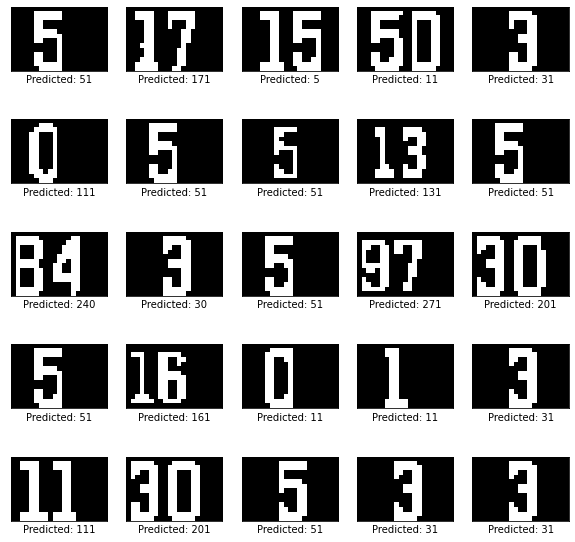

94/94 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000


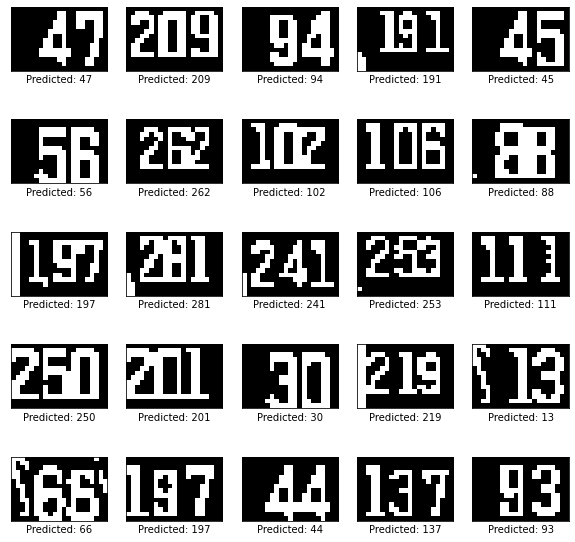

In [9]:
# # model evaluation predict pubg images ---------

test_loss, test_acc = model.evaluate(x_test_pubg, y_test_pubg)
predictions_pubg = model.predict(x_test_pubg)
show_sample(x_test_pubg,['Predicted: %d' % (np.argmax(result)) for result in predictions_pubg])

test_loss, test_acc = model.evaluate(x_train_pubg, y_train_pubg)
predictions_pubg = model.predict(x_train_pubg)
show_sample(x_train_pubg,['Predicted: %d' % (np.argmax(result)) for result in predictions_pubg])

In [10]:
# print(training_history.history)

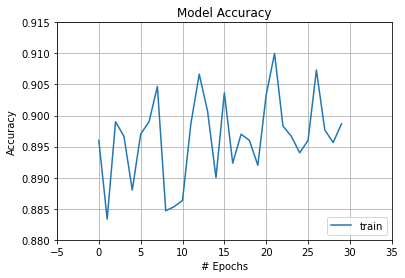

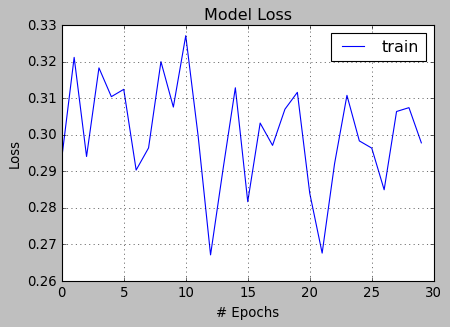

In [11]:
epoch = len(training_history.history.get('loss',[]))

# Draw Model Accuracy
plt.figure(2,figsize=(6,4))
plt.plot(range(epoch),training_history.history['accuracy'])
# plt.plot(range(epoch),training_history.history['val_accuracy'])
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(['train','validation'],loc=4)
plt.style.use(['classic'])

# Draw Model Loss
plt.figure(1,figsize=(6,4))
plt.plot(range(epoch),training_history.history['loss'])
# plt.plot(range(epoch),training_history.history['val_loss'])
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(['train','validation'])

#### MNIST train and validatation

In [11]:
# #Another way
# training_history = model.fit(x_train_pubg, 
#                              y_train_pubg, 
#                              validation_split=0.2,
#                              epochs=600,
#                              batch_size=1024)

Epoch 1/600
3/3 [==============================] - 0s 83ms/step - loss: 6.2173 - accuracy: 0.0017 - val_loss: 6.2067 - val_accuracy: 0.0033
Epoch 2/600
3/3 [==============================] - 0s 38ms/step - loss: 6.1991 - accuracy: 0.0046 - val_loss: 6.1948 - val_accuracy: 0.0067
Epoch 3/600
3/3 [==============================] - 0s 38ms/step - loss: 6.1834 - accuracy: 0.0029 - val_loss: 6.1731 - val_accuracy: 0.0083
Epoch 4/600
3/3 [==============================] - 0s 37ms/step - loss: 6.1586 - accuracy: 0.0042 - val_loss: 6.1399 - val_accuracy: 0.0050
Epoch 5/600
3/3 [==============================] - 0s 37ms/step - loss: 6.1193 - accuracy: 0.0050 - val_loss: 6.0977 - val_accuracy: 0.0017
Epoch 6/600
3/3 [==============================] - 0s 38ms/step - loss: 6.0863 - accuracy: 0.0037 - val_loss: 6.0609 - val_accuracy: 0.0017
Epoch 7/600
3/3 [==============================] - 0s 38ms/step - loss: 6.0370 - accuracy: 0.0042 - val_loss: 6.0298 - val_accuracy: 0.0017
Epoch 8/600
3/3 [===

3/3 [==============================] - 0s 38ms/step - loss: 3.1930 - accuracy: 0.2142 - val_loss: 2.8462 - val_accuracy: 0.3117
Epoch 60/600
3/3 [==============================] - 0s 37ms/step - loss: 3.1035 - accuracy: 0.2233 - val_loss: 2.7439 - val_accuracy: 0.3067
Epoch 61/600
3/3 [==============================] - 0s 37ms/step - loss: 3.0670 - accuracy: 0.2283 - val_loss: 2.6569 - val_accuracy: 0.3167
Epoch 62/600
3/3 [==============================] - 0s 38ms/step - loss: 3.0420 - accuracy: 0.2212 - val_loss: 2.6092 - val_accuracy: 0.3500
Epoch 63/600
3/3 [==============================] - 0s 38ms/step - loss: 2.9872 - accuracy: 0.2429 - val_loss: 2.5794 - val_accuracy: 0.3383
Epoch 64/600
3/3 [==============================] - 0s 37ms/step - loss: 2.9095 - accuracy: 0.2354 - val_loss: 2.5124 - val_accuracy: 0.3567
Epoch 65/600
3/3 [==============================] - 0s 37ms/step - loss: 2.8748 - accuracy: 0.2500 - val_loss: 2.4218 - val_accuracy: 0.3850
Epoch 66/600
3/3 [========

3/3 [==============================] - 0s 38ms/step - loss: 1.3880 - accuracy: 0.5713 - val_loss: 0.8536 - val_accuracy: 0.7733
Epoch 118/600
3/3 [==============================] - 0s 37ms/step - loss: 1.3508 - accuracy: 0.5871 - val_loss: 0.8476 - val_accuracy: 0.7667
Epoch 119/600
3/3 [==============================] - 0s 37ms/step - loss: 1.3511 - accuracy: 0.5854 - val_loss: 0.8281 - val_accuracy: 0.7800
Epoch 120/600
3/3 [==============================] - 0s 38ms/step - loss: 1.3567 - accuracy: 0.5763 - val_loss: 0.8109 - val_accuracy: 0.7700
Epoch 121/600
3/3 [==============================] - 0s 37ms/step - loss: 1.2872 - accuracy: 0.5975 - val_loss: 0.7955 - val_accuracy: 0.7667
Epoch 122/600
3/3 [==============================] - 0s 38ms/step - loss: 1.3149 - accuracy: 0.5813 - val_loss: 0.7720 - val_accuracy: 0.7783
Epoch 123/600
3/3 [==============================] - 0s 38ms/step - loss: 1.2947 - accuracy: 0.5908 - val_loss: 0.7717 - val_accuracy: 0.7833
Epoch 124/600
3/3 [=

Epoch 175/600
3/3 [==============================] - 0s 40ms/step - loss: 0.9190 - accuracy: 0.6996 - val_loss: 0.4388 - val_accuracy: 0.8717
Epoch 176/600
3/3 [==============================] - 0s 36ms/step - loss: 0.9237 - accuracy: 0.7004 - val_loss: 0.4325 - val_accuracy: 0.8700
Epoch 177/600
3/3 [==============================] - 0s 37ms/step - loss: 0.9312 - accuracy: 0.6879 - val_loss: 0.4372 - val_accuracy: 0.8750
Epoch 178/600
3/3 [==============================] - 0s 38ms/step - loss: 0.9195 - accuracy: 0.6988 - val_loss: 0.4372 - val_accuracy: 0.8800
Epoch 179/600
3/3 [==============================] - 0s 38ms/step - loss: 0.9393 - accuracy: 0.6879 - val_loss: 0.4394 - val_accuracy: 0.8683
Epoch 180/600
3/3 [==============================] - 0s 37ms/step - loss: 0.8637 - accuracy: 0.7192 - val_loss: 0.4383 - val_accuracy: 0.8650
Epoch 181/600
3/3 [==============================] - 0s 37ms/step - loss: 0.8925 - accuracy: 0.7158 - val_loss: 0.4385 - val_accuracy: 0.8633
Epoch 

Epoch 233/600
3/3 [==============================] - 0s 38ms/step - loss: 0.7598 - accuracy: 0.7429 - val_loss: 0.3111 - val_accuracy: 0.9100
Epoch 234/600
3/3 [==============================] - 0s 39ms/step - loss: 0.7362 - accuracy: 0.7583 - val_loss: 0.3110 - val_accuracy: 0.8983
Epoch 235/600
3/3 [==============================] - 0s 38ms/step - loss: 0.7187 - accuracy: 0.7571 - val_loss: 0.3064 - val_accuracy: 0.9017
Epoch 236/600
3/3 [==============================] - 0s 37ms/step - loss: 0.7216 - accuracy: 0.7617 - val_loss: 0.2956 - val_accuracy: 0.9083
Epoch 237/600
3/3 [==============================] - 0s 37ms/step - loss: 0.7291 - accuracy: 0.7542 - val_loss: 0.2923 - val_accuracy: 0.9100
Epoch 238/600
3/3 [==============================] - 0s 38ms/step - loss: 0.7245 - accuracy: 0.7521 - val_loss: 0.2910 - val_accuracy: 0.9117
Epoch 239/600
3/3 [==============================] - 0s 37ms/step - loss: 0.7449 - accuracy: 0.7508 - val_loss: 0.2905 - val_accuracy: 0.9117
Epoch 

Epoch 291/600
3/3 [==============================] - 0s 39ms/step - loss: 0.6123 - accuracy: 0.8004 - val_loss: 0.2266 - val_accuracy: 0.9333
Epoch 292/600
3/3 [==============================] - 0s 38ms/step - loss: 0.5968 - accuracy: 0.7983 - val_loss: 0.2321 - val_accuracy: 0.9333
Epoch 293/600
3/3 [==============================] - 0s 40ms/step - loss: 0.6400 - accuracy: 0.7900 - val_loss: 0.2303 - val_accuracy: 0.9317
Epoch 294/600
3/3 [==============================] - 0s 38ms/step - loss: 0.6082 - accuracy: 0.7900 - val_loss: 0.2234 - val_accuracy: 0.9333
Epoch 295/600
3/3 [==============================] - 0s 39ms/step - loss: 0.5965 - accuracy: 0.8008 - val_loss: 0.2199 - val_accuracy: 0.9350
Epoch 296/600
3/3 [==============================] - 0s 38ms/step - loss: 0.5852 - accuracy: 0.8112 - val_loss: 0.2196 - val_accuracy: 0.9383
Epoch 297/600
3/3 [==============================] - 0s 39ms/step - loss: 0.6061 - accuracy: 0.7992 - val_loss: 0.2273 - val_accuracy: 0.9317
Epoch 

Epoch 349/600
3/3 [==============================] - 0s 38ms/step - loss: 0.4900 - accuracy: 0.8338 - val_loss: 0.1960 - val_accuracy: 0.9417
Epoch 350/600
3/3 [==============================] - 0s 38ms/step - loss: 0.5285 - accuracy: 0.8296 - val_loss: 0.1997 - val_accuracy: 0.9400
Epoch 351/600
3/3 [==============================] - 0s 39ms/step - loss: 0.5269 - accuracy: 0.8250 - val_loss: 0.2021 - val_accuracy: 0.9400
Epoch 352/600
3/3 [==============================] - 0s 38ms/step - loss: 0.4972 - accuracy: 0.8279 - val_loss: 0.2017 - val_accuracy: 0.9350
Epoch 353/600
3/3 [==============================] - 0s 37ms/step - loss: 0.5178 - accuracy: 0.8246 - val_loss: 0.1980 - val_accuracy: 0.9400
Epoch 354/600
3/3 [==============================] - 0s 37ms/step - loss: 0.5221 - accuracy: 0.8158 - val_loss: 0.1961 - val_accuracy: 0.9433
Epoch 355/600
3/3 [==============================] - 0s 38ms/step - loss: 0.4759 - accuracy: 0.8379 - val_loss: 0.1871 - val_accuracy: 0.9467
Epoch 

Epoch 407/600
3/3 [==============================] - 0s 38ms/step - loss: 0.4815 - accuracy: 0.8438 - val_loss: 0.1640 - val_accuracy: 0.9433
Epoch 408/600
3/3 [==============================] - 0s 36ms/step - loss: 0.4739 - accuracy: 0.8417 - val_loss: 0.1622 - val_accuracy: 0.9450
Epoch 409/600
3/3 [==============================] - 0s 38ms/step - loss: 0.4820 - accuracy: 0.8363 - val_loss: 0.1621 - val_accuracy: 0.9450
Epoch 410/600
3/3 [==============================] - 0s 37ms/step - loss: 0.4551 - accuracy: 0.8429 - val_loss: 0.1604 - val_accuracy: 0.9483
Epoch 411/600
3/3 [==============================] - 0s 38ms/step - loss: 0.4731 - accuracy: 0.8408 - val_loss: 0.1609 - val_accuracy: 0.9483
Epoch 412/600
3/3 [==============================] - 0s 38ms/step - loss: 0.4544 - accuracy: 0.8508 - val_loss: 0.1585 - val_accuracy: 0.9467
Epoch 413/600
3/3 [==============================] - 0s 37ms/step - loss: 0.4722 - accuracy: 0.8313 - val_loss: 0.1601 - val_accuracy: 0.9500
Epoch 

Epoch 465/600
3/3 [==============================] - 0s 37ms/step - loss: 0.4467 - accuracy: 0.8512 - val_loss: 0.1314 - val_accuracy: 0.9550
Epoch 466/600
3/3 [==============================] - 0s 38ms/step - loss: 0.4289 - accuracy: 0.8629 - val_loss: 0.1259 - val_accuracy: 0.9667
Epoch 467/600
3/3 [==============================] - 0s 37ms/step - loss: 0.4431 - accuracy: 0.8517 - val_loss: 0.1279 - val_accuracy: 0.9633
Epoch 468/600
3/3 [==============================] - 0s 37ms/step - loss: 0.4299 - accuracy: 0.8475 - val_loss: 0.1318 - val_accuracy: 0.9617
Epoch 469/600
3/3 [==============================] - 0s 39ms/step - loss: 0.4391 - accuracy: 0.8500 - val_loss: 0.1338 - val_accuracy: 0.9650
Epoch 470/600
3/3 [==============================] - 0s 37ms/step - loss: 0.4230 - accuracy: 0.8550 - val_loss: 0.1329 - val_accuracy: 0.9633
Epoch 471/600
3/3 [==============================] - 0s 38ms/step - loss: 0.4727 - accuracy: 0.8392 - val_loss: 0.1335 - val_accuracy: 0.9683
Epoch 

Epoch 523/600
3/3 [==============================] - 0s 37ms/step - loss: 0.3884 - accuracy: 0.8683 - val_loss: 0.1147 - val_accuracy: 0.9667
Epoch 524/600
3/3 [==============================] - 0s 36ms/step - loss: 0.4245 - accuracy: 0.8512 - val_loss: 0.1151 - val_accuracy: 0.9650
Epoch 525/600
3/3 [==============================] - 0s 37ms/step - loss: 0.3849 - accuracy: 0.8662 - val_loss: 0.1164 - val_accuracy: 0.9667
Epoch 526/600
3/3 [==============================] - 0s 41ms/step - loss: 0.3890 - accuracy: 0.8637 - val_loss: 0.1201 - val_accuracy: 0.9633
Epoch 527/600
3/3 [==============================] - 0s 39ms/step - loss: 0.4044 - accuracy: 0.8567 - val_loss: 0.1221 - val_accuracy: 0.9633
Epoch 528/600
3/3 [==============================] - 0s 38ms/step - loss: 0.3784 - accuracy: 0.8712 - val_loss: 0.1212 - val_accuracy: 0.9633
Epoch 529/600
3/3 [==============================] - 0s 37ms/step - loss: 0.3849 - accuracy: 0.8650 - val_loss: 0.1176 - val_accuracy: 0.9650
Epoch 

Epoch 581/600
3/3 [==============================] - 0s 37ms/step - loss: 0.3805 - accuracy: 0.8725 - val_loss: 0.1029 - val_accuracy: 0.9667
Epoch 582/600
3/3 [==============================] - 0s 40ms/step - loss: 0.3420 - accuracy: 0.8804 - val_loss: 0.1002 - val_accuracy: 0.9667
Epoch 583/600
3/3 [==============================] - 0s 38ms/step - loss: 0.3417 - accuracy: 0.8788 - val_loss: 0.0988 - val_accuracy: 0.9667
Epoch 584/600
3/3 [==============================] - 0s 37ms/step - loss: 0.3538 - accuracy: 0.8821 - val_loss: 0.0951 - val_accuracy: 0.9633
Epoch 585/600
3/3 [==============================] - 0s 38ms/step - loss: 0.3319 - accuracy: 0.8883 - val_loss: 0.0928 - val_accuracy: 0.9683
Epoch 586/600
3/3 [==============================] - 0s 37ms/step - loss: 0.3332 - accuracy: 0.8842 - val_loss: 0.0954 - val_accuracy: 0.9683
Epoch 587/600
3/3 [==============================] - 0s 37ms/step - loss: 0.3563 - accuracy: 0.8808 - val_loss: 0.0943 - val_accuracy: 0.9667
Epoch 

2/2 [==============================] - 0s 3ms/step - loss: 3.5383 - accuracy: 0.7288


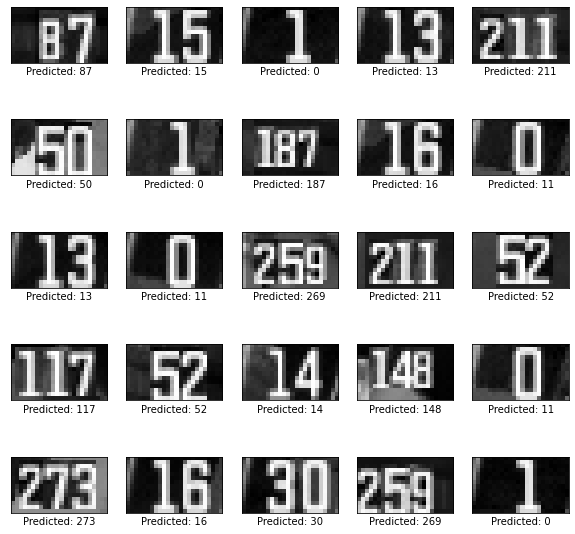

94/94 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9940


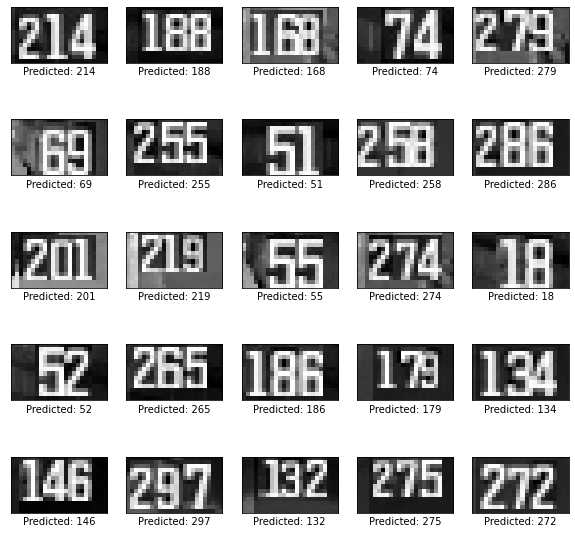

In [12]:
# # model evaluation predict pubg images ---------

test_loss, test_acc = model.evaluate(x_test_pubg, y_test_pubg)
predictions_pubg = model.predict(x_test_pubg)
show_sample(x_test_pubg,['Predicted: %d' % (np.argmax(result)) for result in predictions_pubg])

test_loss, test_acc = model.evaluate(x_train_pubg, y_train_pubg)
predictions_pubg = model.predict(x_train_pubg)
show_sample(x_train_pubg,['Predicted: %d' % (np.argmax(result)) for result in predictions_pubg])

In [13]:
# print(training_history.history)

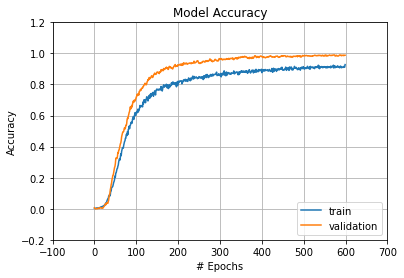

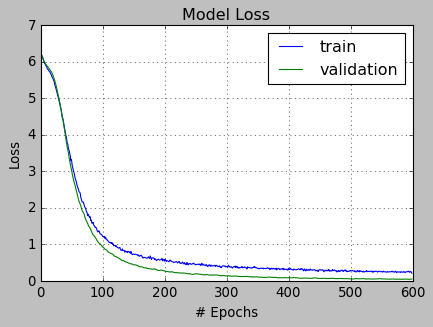

In [14]:
epoch = len(training_history.history.get('loss',[]))

# Draw Model Accuracy
plt.figure(2,figsize=(6,4))
plt.plot(range(epoch),training_history.history['accuracy'])
plt.plot(range(epoch),training_history.history['val_accuracy'])
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(['train','validation'],loc=4)
plt.style.use(['classic'])

# Draw Model Loss
plt.figure(1,figsize=(6,4))
plt.plot(range(epoch),training_history.history['loss'])
plt.plot(range(epoch),training_history.history['val_loss'])
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(['train','validation'])